<a href="https://colab.research.google.com/github/sakurasakura1996/Pytorch-start-learning/blob/master/Dive_into_DL_Pytorch_5_8_%E7%BD%91%E7%BB%9C%E4%B8%AD%E7%9A%84%E7%BD%91%E7%BB%9CNIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5.8 网络中的网络
前面LeNet、AlexNet和VGG在设计上的共同之处是：先由卷积层构成的模块充分抽取空间特征，再以由全连接层构成的模块来输出分类结果。其中，AlexNet和VGG对LeNet的改进主要在于如何对这两个模块加宽（增加通道数）和加深。本节介绍网络中的网络（NiN）他提出了另外一个思路，即**串联多个由卷积层和“全连接”层构成的小网络来构建一个深层网络**
##５.８.１NIN块
我们知道，卷积层的输入和输出通常是四维数组（样本，通道，高，宽）而全连接层的输入和输出则通常是二维数组（样本，特征）。如果想在全连接层后再接上卷积层，则需要将全连接层的输出变换为四维。回以１ｘ１卷积层。它可以看成全连接层，其中空间维度（高和宽）上的每个元素相当于样本，通道相当于特征。因此，NiN使用1x1卷积层来替代全连接层，从而使空间信息能够自然传递到后面的层中去。
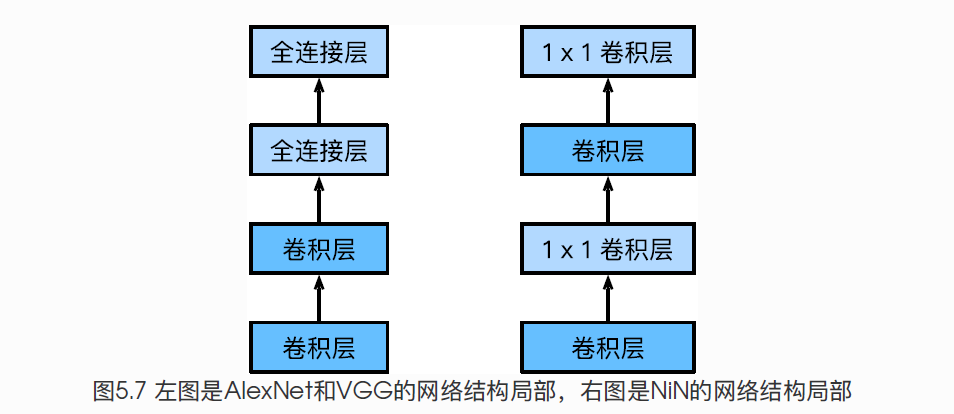
NiN块是NiN中的基础块，他由一个卷积层加两个充当全连接层的1x1卷积层串联而成。其中第一个卷积层的超参数可以自行设置，而第二和第三个卷积层的超参数一般是固定的


In [0]:
import time
import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def nin_block(in_channels, out_channels, kernel_size, stride, padding):
  blk = nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
      nn.ReLU(),
      nn.Conv2d(out_channels,out_channels,kernel_size=1),
      nn.ReLU(),
      nn.Conv2d(out_channels, out_channels, kernel_size=1),
      nn.ReLU()
  )
  return blk

In [0]:
class FlattenLayer(nn.Module):
  def __init__(self):
    super(FlattenLayer, self).__init__()
  def forward(self, x): # x shape: (batch, *, *, ...)
    return x.view(x.shape[0], -1)

In [0]:
# 5.8.2 NIN模型
# NiN去掉了AlexNet最后的3个全连接层，取而代之地，NiN使用了输出通道数等于标签类别数的NiN块，
# 然后使用全局平均池化层对每个通道中所有元素求平均并直接用于分类。这里的全局平均池化层即窗口形状
# 等于输入空间维形状的平均池化层。NiN的这个设计的好处是可以显著减小模型参数尺寸，从而缓解过拟合。
class GlobalAvgPool2d(nn.Module):
  # 全局平均池化层可通过将池化窗口形状设置成输入的高和宽实现
  def __init__(self):
    super(GlobalAvgPool2d,self).__init__()
  def forward(self, x):
    return F.avg_pool2d(x, kernel_size=x.size()[2:])
  
net = nn.Sequential(
    nin_block(1, 96, kernel_size=11, stride=4, padding=0),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nin_block(96, 256, kernel_size=5, stride=1, padding=2),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nin_block(256, 384, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Dropout(0.5),
    # 标签类别数是10
    nin_block(384, 10, kernel_size=3, stride=1, padding=1),
    GlobalAvgPool2d(),
    FlattenLayer()
)

In [5]:
X = torch.rand(1,1,224,224)
for name, blk in net.named_children():
  X = blk(X)
  print(name, 'output shape:' ,X.shape)

0 output shape: torch.Size([1, 96, 54, 54])
1 output shape: torch.Size([1, 96, 26, 26])
2 output shape: torch.Size([1, 256, 26, 26])
3 output shape: torch.Size([1, 256, 12, 12])
4 output shape: torch.Size([1, 384, 12, 12])
5 output shape: torch.Size([1, 384, 5, 5])
6 output shape: torch.Size([1, 384, 5, 5])
7 output shape: torch.Size([1, 10, 5, 5])
8 output shape: torch.Size([1, 10, 1, 1])
9 output shape: torch.Size([1, 10])


In [0]:
def load_data_fashion_mnist(batch_size, resize=None):
  trans = []
  if resize:
    trans.append(torchvision.transforms.Resize(size=resize))
  trans.append(torchvision.transforms.ToTensor())

  transform = torchvision.transforms.Compose(trans)
  mnist_train = torchvision.datasets.FashionMNIST(root='~/Datasets/FashionMNIST',train=True,transform=transform,download=True)
  mnist_test = torchvision.datasets.FashionMNIST(root='~/Datasets/FashionMNIST',train=False,transform=transform,download=True)

  train_iter = torch.utils.data.DataLoader(mnist_train,batch_size=batch_size,shuffle=True,num_workers=4)
  test_iter = torch.utils.data.DataLoader(mnist_test,batch_size=batch_size,shuffle=False,num_workers=4)
  return train_iter, test_iter




In [9]:
batch_size = 128
train_iter, test_iter = load_data_fashion_mnist(batch_size,resize=224)

lr = 0.002
num_epochs = 5
optimizer = torch.optim.Adam(net.parameters(),lr=lr)



Extracting /root/Datasets/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/Datasets/FashionMNIST/FashionMNIST/raw



Extracting /root/Datasets/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/Datasets/FashionMNIST/FashionMNIST/raw



Extracting /root/Datasets/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/Datasets/FashionMNIST/FashionMNIST/raw



Extracting /root/Datasets/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/Datasets/FashionMNIST/FashionMNIST/raw
Processing...
Done!


In [0]:
def evaluate_accuracy(data_iter, net, device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
  acc_sum, n =0.0, 0
  with torch.no_grad():
    for X,y in data_iter:
      if isinstance(net, torch.nn.Module):
        net.eval()   # 评估模式，这回关闭dropout
        acc_sum += (net(X.to(device)).argmax(dim=1) == y.to(device)).float().sum().cpu().item()
        net.train()  # 改回训练模式
      else:
        if('is_training' in net.__code__.co_varnames):
          acc_sum += (net(X,is_training=False).argmax(dim=1) == y).float().sum().item()
        else:
          acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
      n += y.shape[0]
  return acc_sum / n

In [0]:
def train_ch5(net, train_iter, test_iter, batch_size, optimizer, device, num_epochs):
  net = net.to(device)
  print("training on ",device)
  loss = torch.nn.CrossEntropyLoss()
  batch_count = 0
  for epoch in range(num_epochs):
    train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
    for X,y in train_iter:
      X = X.to(device)
      y = y.to(device)
      y_hat = net(X)
      l = loss(y_hat,y)
      optimizer.zero_grad()
      l.backward()
      optimizer.step()
      train_l_sum += l.cpu().item()
      train_acc_sum +=(y_hat.argmax(dim=1) == y).sum().cpu().item()
      n += y.shape[0]
      batch_count +=1
    test_acc = evaluate_accuracy(test_iter, net)
    print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f,time %.1f sec'% (epoch + 1, train_l_sum / batch_count,train_acc_sum / n, test_acc, time.time() - start))

In [13]:
train_ch5(net,train_iter,test_iter,batch_size,optimizer,device,num_epochs)

training on  cuda
epoch 1, loss 1.2168, train acc 0.556, test acc 0.742,time 64.8 sec
epoch 2, loss 0.2944, train acc 0.788, test acc 0.819,time 68.3 sec
epoch 3, loss 0.1579, train acc 0.827, test acc 0.839,time 68.0 sec
epoch 4, loss 0.1080, train acc 0.842, test acc 0.839,time 68.1 sec
epoch 5, loss 0.0790, train acc 0.856, test acc 0.858,time 68.1 sec
